In [27]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os
from datetime import datetime

from pyannote.audio import Pipeline
from pyannote.core import json

from matplotlib import pyplot as plt, lines
import seaborn as sns

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler

from scipy import stats
from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist

from src import (
    downsample as downsamp_audio, 
    embedding_extractor as ee, 
    dimension_reducer as dr, 
    distance_metrics as dm, 
    downsample as ds,
    emb_manipulator as em
)

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
##Downsample audio to 16kHz
root_dir= "/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/053122_new_participants/"
audio_files = os.path.join(root_dir,"audio")

#make a folder with today's date for the downsampled audio
down_sample_dir = os.path.join(root_dir,'audio_16kHz')

if not os.path.exists(down_sample_dir):
    os.mkdir(down_sample_dir)

In [ ]:
ds.downsamp_audio(audio_files, down_sample_dir)

processing023.wav


In [28]:
##Diarize audio to find when mother is speaking and visualize it to choose label

diar_dir = os.path.join(root_dir,'diarized')
  
if not os.path.exists(diar_dir):
    os.mkdir(diar_dir)

In [ ]:
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization")

for file in os.listdir(down_sample_dir):
    if file.endswith('wav'):
        diar = pipeline(os.path.join(down_sample_dir,file))
        json.dump_to(diar, os.path.join(diar_dir, os.path.splitext(file)[0]+'.json'))

In [8]:
# Based on output of diarization, manually make speaker map to set which speaker we want
speaker_map = {'021':'SPEAKER_01', '022':'SPEAKER_00', 'BB003':'SPEAKER_00'}

In [9]:
diarized = {os.path.splitext(file)[0]:
            json.load_from(os.path.join(diar_dir,file)).label_timeline(
                speaker_map[os.path.splitext(file)[0]]) 
            for file in os.listdir(diar_dir)}

In [10]:
emb_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings'
save_name = datetime.now().strftime('%Y_%m_%d') + '_emb.csv'

In [75]:
pyannote_emb = ee.pyannote_extract_directory(down_sample_dir, diarized,emb_dir,save_name,save=True)

Processing022.wav
Done


In [11]:
files = ['03016_diarized_pyv2.csv','2022_06_01_emb.csv']

emb_unscaled = pd.DataFrame()

for f in files:
    emb_unscaled = pd.concat([emb_unscaled,pd.read_csv(os.path.join(emb_dir,f), index_col=0)], ignore_index=True)

#emb_down_unscaled = em.resample_data(emb,1)

scaler = StandardScaler()
emb = pd.DataFrame(scaler.fit_transform(emb_unscaled.drop(columns='part_id')))
emb['part_id'] = emb_unscaled.part_id.astype('string').to_numpy()


In [17]:
min_dist=0.1
dim = 2
n_neighbors = 10

#run umap with default parameters
emb_umap = dr.run_umap(emb, n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, metric='euclidean')

knn=50
knn_classes=4
subsetsize=700

#we are always comparing to emb_down as our high-dimension embedding. 
high_dim = emb.drop(columns='part_id').to_numpy()
classes= emb.part_id.to_numpy() #extract the categories/labels

#compare tsne to embeddings
#low_dim = emb_tsne.drop(columns='part_id').to_numpy()
#dist_tsne = dm.embedding_quality(high_dim, low_dim, classes, knn=knn, knn_classes=knn_classes, subsetsize=subsetsize)

#compare umap to embeddings
low_dim = emb_umap.drop(columns='part_id').to_numpy()
dist_umap = dm.embedding_quality(high_dim, low_dim, classes, knn=knn, knn_classes=knn_classes, subsetsize=subsetsize)


#create a dataframe of all distance metrics for each dimension method
#dist = pd.DataFrame(np.vstack((dist_tsne, dist_umap)), columns = ['micro', 'meso', 'macro'], index = ['tsne', 'umap'])
dist = pd.DataFrame(dist_umap, index = ['micro', 'meso', 'macro'], columns= ['umap'])
dist = dist.round(decimals=3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[Text(0.5, 1.0, 'micro    0.508\nmeso     0.446\nmacro    0.338\nName: umap, dtype: float64')]

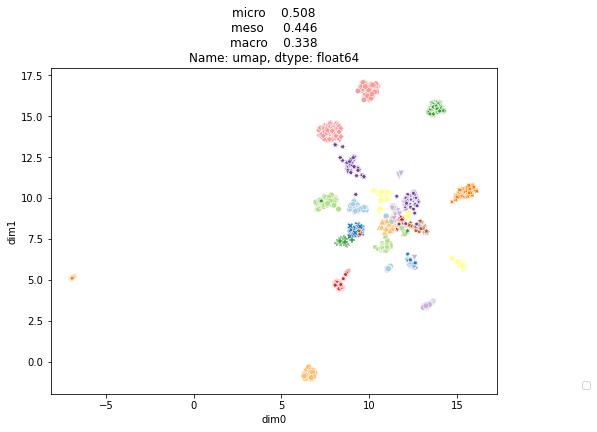

In [29]:
##plot 2 dimensions from each dimension reduction
fig, ax1 = plt.subplots(figsize=(8,6))
#fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6))


clust_plt_umap = sns.scatterplot(x=emb_umap.dim0, y=emb_umap.dim1, ax=ax1, palette="Paired", hue=emb_umap.part_id, style=emb_umap.part_id, legend=False)
ax1.legend(loc="lower center",bbox_to_anchor=(1.2,  0), ncol=1)
clust_plt_umap.set(title = str(dist.umap))

#clust_plt_tsne = sns.scatterplot(x=emb_tsne.dim0, y=emb_tsne.dim1, ax=ax2, palette="Paired", hue=emb_tsne.part_id, style=emb_tsne.part_id)
#ax2.legend(loc="lower center",bbox_to_anchor=(1.2,  0), ncol=1)
#clust_plt_tsne.set(title = str(dist[dist.index=='tsne']))

In [15]:
haus_umap = dm.hausdorff_distances(emb_umap)

Processing row 22, col 22


In [190]:
target = 'BB003'
haus_umap[target].abs().nlargest(n=6)

9     1.950996
20    1.718922
17    1.643011
4     1.370533
8     1.341575
7     1.195566
Name: BB003, dtype: float64

In [191]:
haus_tsne[target].abs().nlargest(n=6)

18    2.246877
6     1.711038
3     1.505112
20    1.403984
8     1.273288
11    1.213728
Name: BB003, dtype: float64

In [34]:
import librosa

In [57]:
librosa_files_1 = r'/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/0300222_recordings_16khz'
librosa_files_2 = r'/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/053122_new_participants/audio_16kHz'
wav_files = [os.path.join(librosa_files_1, file) for file in os.listdir(librosa_files_1)]
wav_files.extend([os.path.join(librosa_files_2, file) for file in os.listdir(librosa_files_2)])

In [59]:
wav_data = [librosa.load(wav, sr=16000, mono=True) for wav in wav_files]

In [69]:
l = 0
for wav in wav_data:
    l = l + wav[0].shape[0]   
l

176431786

In [85]:
## shape/(framelength/4) + 1 = num_embed
## num_embed-1 = shape/(framelength/4)
## 1/(num_embed-1) = (framelength/4)/shape
## shape/(num_embed-1) = framelength/4
## 4 * shape/(num_embed-1) = framelength

frame_length = 4*l//(emb.shape[0]-1)

f0 = [librosa.yin(wav[0], 
                  sr=16000,
                  frame_length=639246,
                  fmin = librosa.note_to_hz('C2'), 
                  fmax= librosa.note_to_hz('C7')) 
      for wav in wav_data]

In [159]:
len([f for f in f0_flat if f<500])

677

In [168]:
test = [1,2,3,4]

list(np.repeat(test,2))

[1, 1, 2, 2, 3, 3, 4, 4]

In [164]:
teset

[[1, 1], [2, 2], [3, 3], [4, 4]]

In [173]:
import random
f0_flat = list(np.concatenate(f0).flat)
f0_flat = [f for f in f0_flat if f<500]
f0_flat = list(np.repeat(f0_flat,2))

prune = random.sample(range(1,len(f0_flat)),len(f0_flat)-emb.shape[0])

for skip in sorted(prune, reverse=True):
    del f0_flat[skip]
    
emb['f0'] = f0_flat

<AxesSubplot:xlabel='dim0', ylabel='dim1'>

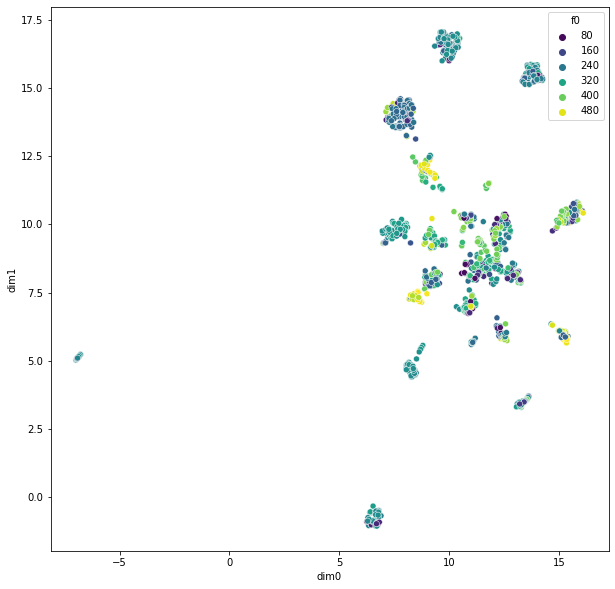

In [174]:
fig = plt.figure(figsize=(10,10))
sns.scatterplot(x=emb_umap.dim0, y=emb_umap.dim1, hue=emb.f0, palette="viridis")

In [176]:
emb[emb.f0 <100]

,0,1,2,3,4,5,6,7,8,9,...,504,505,506,507,508,509,510,511,part_id,f0
95,-0.741048,-0.269076,-0.173646,-1.291493,-2.047545,-1.700943,0.589375,-1.704295,0.517545,0.261343,...,1.164895,1.391953,0.876179,-0.277827,-0.047143,-1.315267,1.239920,-1.555998,15,90.270974
96,-0.870690,-0.121168,0.227202,-0.981290,-1.124283,-2.115840,0.438522,-1.621637,-0.004264,0.599822,...,1.292918,1.196963,1.724141,-0.224133,-0.383643,-0.889160,2.226241,-0.824937,15,90.270946
97,-0.684852,-0.241196,1.359825,-0.420736,-0.358739,-1.760954,0.873304,-2.152131,-0.200274,-0.081948,...,-0.466804,1.493413,0.097373,0.276770,0.602773,-1.145164,1.722400,-0.976377,15,90.270946
98,-1.280341,0.493594,-0.835868,-0.491093,-0.824767,-1.504369,1.211786,-0.915546,-0.528375,0.397089,...,-0.927009,1.682264,0.545096,0.603572,-0.625910,-1.733664,1.652617,-1.007527,15,90.270973
99,-0.651243,-0.833917,0.001029,-0.510768,-1.134201,-2.389656,1.693669,-0.305884,-1.133216,1.345385,...,0.002073,1.170133,1.232941,1.323601,-1.015922,-1.033176,2.089922,-0.252100,15,90.270973
254,-0.344988,-0.753737,-0.034480,-1.417622,-0.603289,0.033796,0.296797,-0.265009,1.118124,1.000363,...,0.517024,-0.569334,1.719728,0.360269,1.524710,1.910972,-1.766520,-1.720605,2,81.064253
255,0.233659,-0.765932,0.450399,-1.228599,-0.670570,0.004463,-0.432828,0.497044,0.759618,0.275646,...,-0.520979,0.222617,1.131763,0.144939,1.311290,0.658833,1.113538,-0.390472,2,81.064253
271,-0.581700,1.165155,0.364263,2.446183,1.960512,-0.982655,-0.320223,-2.312680,1.669222,0.406976,...,-0.102038,-1.276983,0.707670,-1.368395,-0.384810,-0.368356,-0.874648,0.368189,2,80.583316
272,-0.620666,0.982736,0.300859,1.974975,2.160888,-1.362272,0.090140,-1.389301,1.704209,0.404286,...,-1.030439,-0.689130,0.872222,-1.141273,-0.982651,0.261363,-1.385656,0.092534,2,80.583316
273,0.345331,1.017606,-0.272412,2.019845,1.550167,-1.081262,-1.055106,-0.371457,2.018312,1.076173,...,-0.641599,-0.152205,1.565155,-1.322878,-0.524871,0.118753,0.894111,0.563046,2,80.447187
